# LSTM 예제 코드 필사하고 이해하기 - Part 1

<br>

<br>

#### 참고한 LSTM Code
[Pytorch ver.1](https://cnvrg.io/pytorch-lstm/?gclid=Cj0KCQiA6t6ABhDMARIsAONIYyxsIXn6G6EcMLhGnPDxnsKiv3zLU49TRMxsyTPXZmOV3E-Hh4xeI2EaAugLEALw_wcB)
<br>
[Pytorch ver.2](https://stackabuse.com/time-series-prediction-using-lstm-with-pytorch-in-python/)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

from keras.callbacks import EarlyStopping

## Data Preparation
사용데이터: 스타벅스 Stock volumne 데이터

In [2]:
df = pd.read_csv('SBUX.csv', index_col = 'Date', parse_dates=True)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-12-11,86.260002,86.870003,85.849998,86.589996,84.480545,4921900
2019-12-12,88.000000,88.889999,87.540001,88.209999,86.061089,10282100
2019-12-13,88.019997,88.790001,87.580002,88.669998,86.509880,6714100
2019-12-16,89.139999,89.300003,88.430000,88.779999,86.617203,6705600
2019-12-17,88.870003,88.970001,87.470001,88.129997,85.983040,7296900


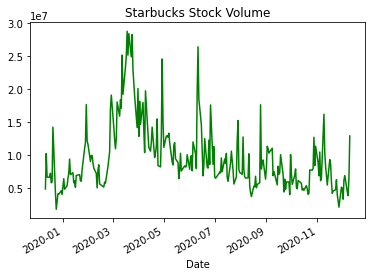

In [3]:
df['Volume'].plot(color = 'green', title = 'Starbucks Stock Volume')
plt.show()

In [4]:
X = df.iloc[:, :-1]
y = df.iloc[:, 5:6]

In [5]:
# data standardization
mm = MinMaxScaler()
ss = StandardScaler()

X_ss = ss.fit_transform(X)
y_mm = mm.fit_transform(y) 

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_ss, y_mm, test_size = 0.2, random_state = 0)

## 1-1. Pytorch ver.1

### Step1: Convert data to tensor
Pytorch로 LSTM 모델을 구현하기 위해서는 input data의 형태를 numpy에서 tensor로 변환해야한다. `torch.Tensor`을 이용하면 변환이 가능하다. 여기서 `Variable`을 걸어주었는데, 이는 향후 모델 optimize를 할 때 순전파, 역전파 및 gradient 계산을 원활히 할 수 있도록 도와주는 pytorch tensor의 wrapper이다.


In [7]:
X_train_tensor = Variable(torch.Tensor(X_train))
X_test_tensor = Variable(torch.Tensor(X_test))
y_train_tensor = Variable(torch.Tensor(y_train))
y_test_tensor = Variable(torch.Tensor(y_test)) 

### Step2: Reshaping data to sequence form
LSTM 모델은 sequential data를 처리하기 위한 모델이기 때문에 일반적으로 사용하는 2-D array를 적용할 수 없다. 따라서 timestamp를 포함하도록 데이터를 재구조화 해야한다. 

 + 구조: (number of data, timestamp, features)

In [8]:
# reshaping tensor
X_train_tensor_final = torch.reshape(X_train_tensor, (X_train_tensor.shape[0], 1, X_train_tensor.shape[1]))
X_test_tensor_final = torch.reshape(X_test_tensor, (X_test_tensor.shape[0], 1, X_test_tensor.shape[1])) 

In [26]:
print(X_train_tensor_final.shape)
print(X_test_tensor_final.shape)

torch.Size([202, 1, 5])
torch.Size([51, 1, 5])


### Step3: LSTM Model
`torch.nn.LSTM`을 이용하면 LSTM 모델을 쉽게 구현할 수 있다. `torch.nn.LSTM` 함수는 forget gate, input gate, cell state, output gate를 처리하는 과정을 모두 담고있다. 자세한 설명은 [Pytorch 공식 설명](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)을 참고하면 된다.


필사를 하기 위해 다양한 코드를 살펴보았는데, LSTM 모델링은 대부분 클래스를 통해 구현되었다. 하나씩 살펴보면 다음과 같다.

#### (1) LSTM model 클래스 구조
1. `__init__`
  + LSTM 모델의 기본 setting 및 모델 구조를 설정하는 단계
  + `super(model, self).__init__()`를 이용해 이 단계에서 설정하는 기본 setting이 전역적으로 적용되게 설정한다.
  + 모델 구조는 상황에 맞게 설정한다. 기본적으로 **nn.LSTM - nn.Linear** 구조로, LSTM 모델로 output을 만든 후, Dense layer를 거쳐 최종 output을 만드는 구조로 만든다. (nn.Linear에서 활성화함수를 적용하면 된다.)
 
2. forward
  + input data를 받아 `__init__` 단계에서 구축한 모델을 이용해 output prediction을 하는 단계
  + hidden layer와 cell state의 inital state를 0으로 설정한다. 모델 학습 후 최종 timestamp에서의 hidden state와 cell state를 확인할 수 있다.
  
<br>
<br>

**LSTM parameters** <br>
 + `input_size`: input data의 feature 수
 + `hidden_size`: hidden state에 있는 feature 수(hidden nodes)
 + `num_layers`: LSTM 모델을 몇 개의 layer로 쌓을지를 결정
 + `dropout`: Dropout layer 역할 수행. 몇 %를 dropout 할 것인지를 결정
 + `batch_first`: If True, then the input and output tensors are provided as (batch, seq, feature)
 + `bidirectional`: 양방향 LSTM을 구현할 것인지를 결정하는 요소. 양방향 LSTM에 대해 간단히 설명하자면, 예를 들어 NLP를 LSTM을 이용해서 구현할 때, '나는 00를 뒤집어 쓰고 펑펑 울었다.' 에서 00에 해당하는 단어를 유추할 때 '나는' 보다는 '뒤집어 쓰고 펑펑 울었다' 부분을 분석하는 것이 더 유리하다. 즉, 일방향 LSTM이라면 00에 해당하는 단어를 '나는'을 통해 유추해야 하지만, 양방향 LSTM이라면 뒤에서부터도 LSTM을 진행하기 때문에 '뒤집에 쓰고 펑펑 울었다'를 이용해 00을 유추할 수 있는 것이다.

In [29]:
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM, self).__init__()
        self.num_classes = num_classes
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers,
                           batch_first = True)
        
        self.fc_1 = nn.Linear(hidden_size, 128)
        self.fc = nn.Linear(128, num_classes)
        
        self.relu = nn.ReLU()
        
    def forward(self, x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) # initial hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) # initial cell state
        
        output, (hn, cn) = self.lstm(x, (h_0, c_0))
        hn = hn.view(-1, self.hidden_size)
        out = self.relu(hn)
        out = self.fc_1(out)
        out = self.relu(out)
        out = self.fc(out)
        
        return out

In [30]:
# model parameter 설정
num_epochs = 1000 
learning_rate = 0.001 

input_size = 5  
hidden_size = 10
num_layers = 1

num_classes = 1 

In [31]:
lstm1 = LSTM(num_classes, input_size, hidden_size, num_layers, X_train_tensor_final.shape[1])

### Step4: Define loss and optimizer
1. Loss function 설정
 + `torch.nn`을 사용해 사용할 loss 함수를 지정한다.
2. Optimizer 설정
 + `torch.optim`을 사용해 otpimizer 함수를 지정한다. 이 때 input으로 앞서 구축한 모델 파라미터(`model.parameters()`)와 학습률(learning_rate)를 설정한다.
 
3. Epoch 마다 모델 학습 및 가중치 update
 + loss function에 gradient descent를 하여 가중치를 update할 때 꼭 다음 순서로 진행해야 한다.
```python
# 가중치 매개변수 변화율을 0으로 설정 - 이유: pytorch에서는 가중치 업데이트를 할 때 누적해서 계산하기 때문에 zero_grade()를 이용해 0으로 초기화 해야한다.
optimizer.zero_grad() 
# Back Propagation
loss.backward()
# 가중치 업데이트
optimizer.step() 
```

In [32]:
mse = torch.nn.MSELoss()
optimizer = torch.optim.Adam(lstm1.parameters(), lr = learning_rate)

In [33]:
for epoch in range(num_epochs):
    outputs = lstm1.forward(X_train_tensor_final)
    optimizer.zero_grad() 
    
    loss = mse(outputs, y_train_tensor)
    loss.backward() 
    
    optimizer.step() 
    
    if epoch % 100 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item())) 

Epoch: 0, loss: 0.11529
Epoch: 100, loss: 0.01636
Epoch: 200, loss: 0.01471
Epoch: 300, loss: 0.01407
Epoch: 400, loss: 0.01232
Epoch: 500, loss: 0.01014
Epoch: 600, loss: 0.00924
Epoch: 700, loss: 0.00870
Epoch: 800, loss: 0.00845
Epoch: 900, loss: 0.00830


### Step5: Prediction

In [34]:
df_X_ss = ss.transform(df.iloc[:, :-1]) 
df_y_mm = mm.transform(df.iloc[:, -1:]) 

df_X_ss = Variable(torch.Tensor(df_X_ss)) 
df_y_mm = Variable(torch.Tensor(df_y_mm))

# reshape input data
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 1, df_X_ss.shape[1]))

In [35]:
train_pred = lstm1(df_X_ss)
data_pred = train_pred.data.numpy()
datay_plot = df_y_mm.data.numpy()

In [36]:
# 데이터 scaling 전 형태로 변환하기
data_pred = mm.inverse_transform(data_pred)
datay_plot = mm.inverse_transform(datay_plot)

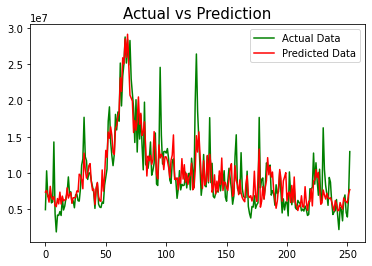

In [41]:
plt.plot(datay_plot, label='Actual Data', color = 'green')
plt.plot(data_pred, label='Predicted Data', color = 'red')
plt.title('Actual vs Prediction', fontsize = 15)
plt.legend()
plt.show()

## 2. Keras
Keras를 이용해 LSTM을 구현하는 것은 pytorch 보다는 간단하다. 내장되어있는 `keras.layers.LSTM` 함수를 이용하면 쉽게 구현할 수 있다. Keras로 딥러닝을 구현하는 방법에 대한 해설은 이전 필사에서 자세히 다뤘기 때문에 생략한다.

### Step1: Reshaping data to sequential form
Pytorch와 마찬가지로 데이터를 sequential 형태로 reshaping 해준다. Format은 동일하다.

In [55]:
X_train_t = X_train.reshape(X_train.shape[0], 1, 5) 
X_test_t = X_test.reshape(X_test.shape[0], 1, 5)

### Step2: Keras LSTM Model
+ LSTM 계층
```python
model.add(LSTM(number of hidden nodes, input_shape = ( , ))
```
 + input_shape: (timestamp, feature) 로 지정


In [66]:
from keras.layers import LSTM 
from keras.models import Sequential 
from keras.layers import Dense 
from keras.callbacks import EarlyStopping 

model = Sequential() # Sequeatial Model 
model.add(LSTM(10, input_shape=(1, 5))) # (timestep, feature) 
model.add(Dense(128))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam') 
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 10)                640       
_________________________________________________________________
dense_3 (Dense)              (None, 128)               1408      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 2,177
Trainable params: 2,177
Non-trainable params: 0
_________________________________________________________________


In [67]:
# callbacks 
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)

model.fit(X_train_t, y_train, epochs = 100, batch_size = 30, verbose = 1, callbacks = [early_stop])

Epoch 1/100
7/7 [==============================] - 3s 2ms/step - loss: 0.1101
Epoch 2/100
7/7 [==============================] - 0s 3ms/step - loss: 0.0520
Epoch 3/100
7/7 [==============================] - 0s 3ms/step - loss: 0.0194
Epoch 4/100
7/7 [==============================] - 0s 3ms/step - loss: 0.0189
Epoch 5/100
7/7 [==============================] - 0s 3ms/step - loss: 0.0205
Epoch 6/100
7/7 [==============================] - 0s 3ms/step - loss: 0.0179
Epoch 7/100
7/7 [==============================] - 0s 3ms/step - loss: 0.0166
Epoch 8/100
7/7 [==============================] - 0s 3ms/step - loss: 0.0185
Epoch 9/100
7/7 [==============================] - 0s 3ms/step - loss: 0.0218
Epoch 10/100
7/7 [==============================] - 0s 3ms/step - loss: 0.0167
Epoch 11/100
7/7 [==============================] - 0s 3ms/step - loss: 0.0150
Epoch 12/100
7/7 [==============================] - 0s 3ms/step - loss: 0.0148
Epoch 13/100
7/7 [==============================] - 0s 3ms/st